# $\Phi$-SO demo

## Packages import

In [1]:
# conda env
try:
    get_ipython().system('echo $CONDA_PREFIX')
except:
    pass

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO


In [2]:
try:
    %matplotlib inline
    #get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

In [3]:
# External packages
import torch
import numpy as np

# Pyplot
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

In [4]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [5]:
torch.cuda.is_available()

False

## Test case

In [6]:
data_size = int(1e3)

In [7]:
# Data points
t  = np.random.uniform(np.pi, 10*np.pi, data_size)
X_array = np.stack((t,), axis=0)
f      = 0.784
alpha0 = 1/9.89
phi    = 0.997
y_array = np.exp(-t*alpha0)*np.cos(f*t + phi)

# One of many symbolic solutions:
target_program_str = ["mul", "exp", "neg", "mul", "t", "alpha0", "cos", "add", "mul", "f", "t", "phi",]
print(len(target_program_str))


12


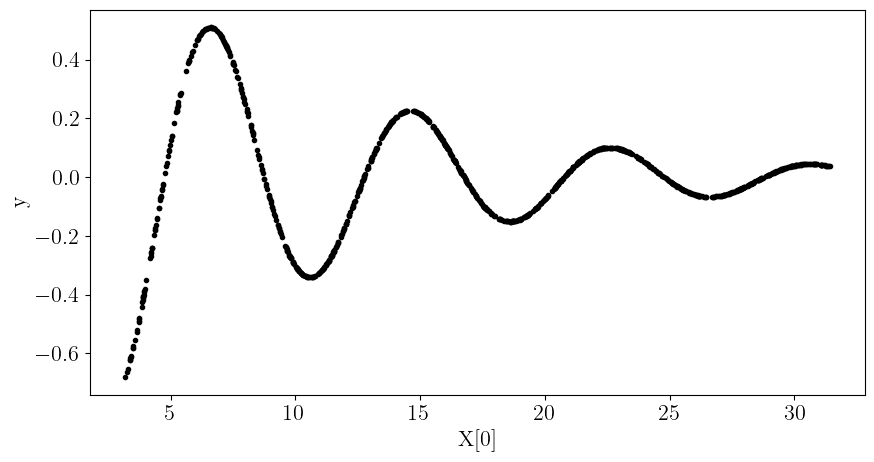

In [8]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [9]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array( 1.   )).to(DEVICE)
#f      = torch.tensor(np.array( f    )).to(DEVICE)
#phi    = torch.tensor(np.array( phi  )).to(DEVICE)

## Run config

### Library config

In [10]:
# [length, mass, time]
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "neg", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"t" : 0         ,},
                "input_var_units"      : {"t" : [0, 0, 1] ,},
                "input_var_complexity" : {"t" : 1.        ,},
                # constants
                "constants"            : {"1" : const1    , },
                "constants_units"      : {"1" : [0, 0, 0] , },
                "constants_complexity" : {"1" : 1.        , },
                # free constants
                "free_constants"            : {"f"               , "alpha0"               , "phi"               , },
                "free_constants_init_val"   : {"f" : 1.          , "alpha0" : 1/10.       , "phi" : 1.          , },
                "free_constants_units"      : {"f" : [0, 0, -1]  , "alpha0" : [0, 0, -1]  , "phi" : [0, 0, 0]   , },
                "free_constants_complexity" : {"f" : 1.          , "alpha0" : 1.          , "phi" : 1.          , },
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [0, 0, 0],
                  "superparent_name"  : "F",
                }


### Learning config

In [11]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, 
                 "zero_out_unphysical" : True, # PHYSICALITY
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                }

In [12]:
MAX_TRIAL_EXPRESSIONS = 2*1e6
BATCH_SIZE = int(1e4)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [13]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e9), #int(MAX_TRIAL_EXPRESSIONS/BATCH_SIZE),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

### Free constant optimizer config

In [14]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 15,
                        'tol'     : 1e-6,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Priors config

In [15]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 8, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                ("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                ("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),           
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

### Cell config

In [16]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

### Logger

In [17]:
save_path_training_curves = 'harmonic_curves.png'
save_path_log             = 'harmonic.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [18]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

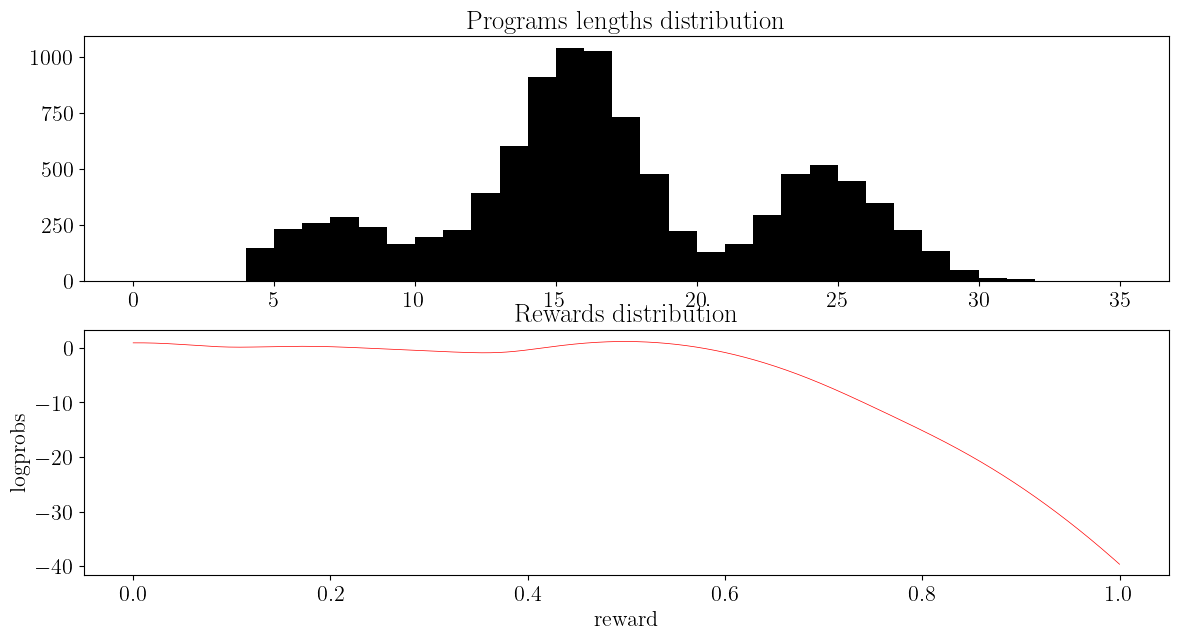

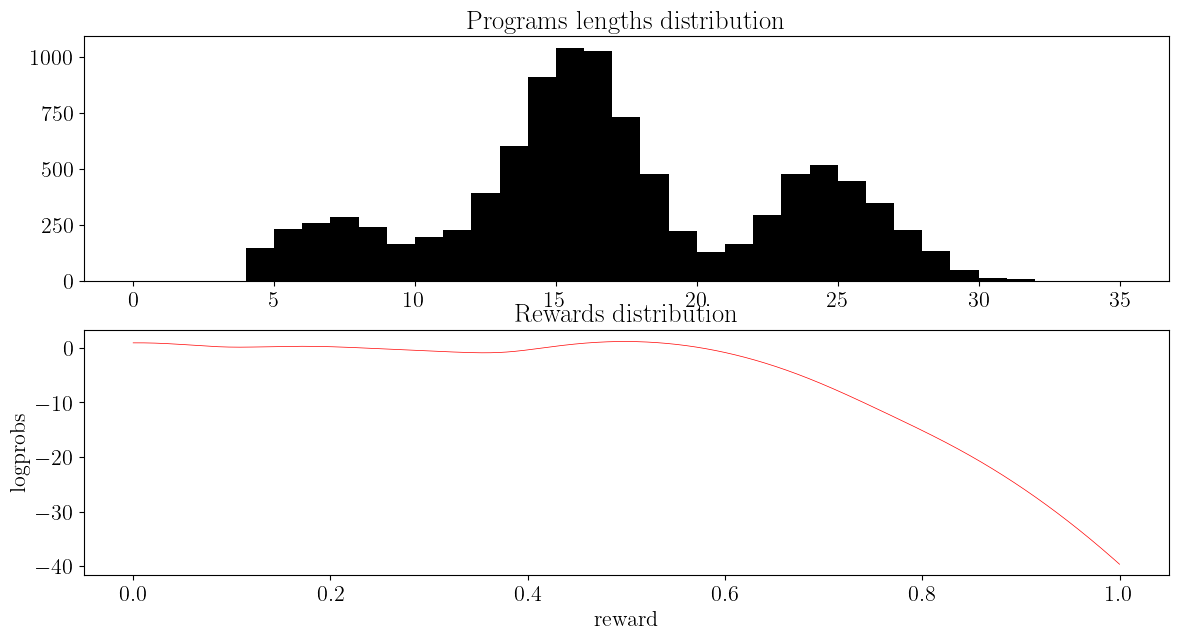

In [19]:
benchmark.dummy_epoch(X, y, run_config)

## Sanity checks

Data


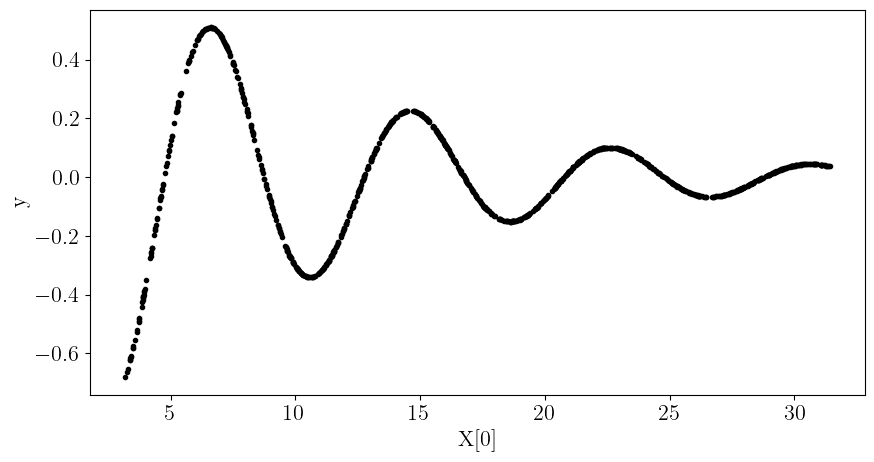

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, 'neg': 7, 'exp': 8, 'log': 9, 'sin': 10, 'cos': 11, '1': 12, 'alpha0': 13, 'f': 14, 'phi': 15, 't': 16}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt neg exp log sin cos 1 alpha0 f phi t F dummy
 -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 8, scale = 5)
- NoUselessInversePrior (['inv', 'neg', 'log', 'exp', 'n2', 'sqrt'] can not be child of ['inv', 'neg', 'exp', 'log', 'sqrt', 'n2'])
- PhysicalUnitsPrior
- NestedFunctions (tokens = ['exp'], nesting forbidden)
- NestedFunctions (tokens = ['log'], nesting forbidden)
- NestedTrigonometryPrior (tokens = ['sin' 'cos'], nesting forbidden)
-------------------------- Dataset -------------------------
X        : torch.Size([1, 1000]) 
y_target : torch.Size([1000])
-------------------------- Programs --------------

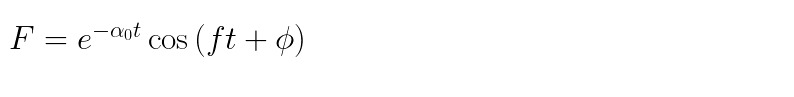

Simplified expression:


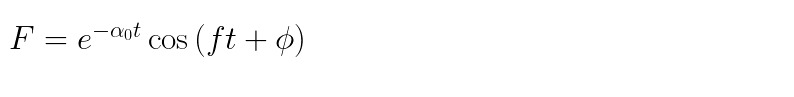

free const opti time = 9.972959 ms
free constants found: tensor([0.1011, 0.7840, 0.9970], dtype=torch.float64, requires_grad=True)


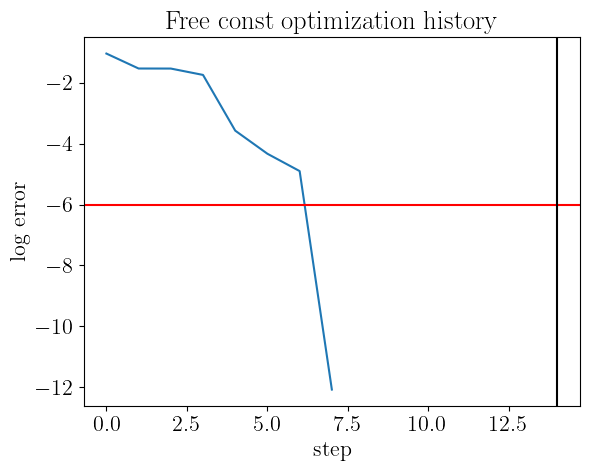

Ideal reward : 0.9999954168740938


In [20]:
target_program = benchmark.sanity_check(X, y, run_config, 
                                        target_program_str = target_program_str,
                                        expected_ideal_reward = 0.9999,
                                       )

## Run

In [ ]:
rewards, candidates = physo.fit (X, y, run_config,
                                stop_reward = 0.9999, 
                                stop_after_n_epochs = 400)

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00000 ===========
-> Time 11.93 s

Overall best  at R=0.631930
-> Raw expression : 
       ⎛- -f ⎞
φ + cos⎜─────⎟
       ⎜ ⎛1⎞ ⎟
       ⎜ ⎜─⎟ ⎟
       ⎝ ⎝t⎠ ⎠
──────────────
        0.5   
   (f⋅t)      

Best of epoch at R=0.631930
-> Raw expression : 
       ⎛- -f ⎞
φ + cos⎜─────⎟
       ⎜ ⎛1⎞ ⎟
       ⎜ ⎜─⎟ ⎟
       ⎝ ⎝t⎠ ⎠
──────────────
        0.5   
   (f⋅t)      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00001 ===========
-> Time 176.15 s

Overall best  at R=0.631930
-> Raw expression : 
       ⎛- -f ⎞
φ + cos⎜─────⎟
       ⎜ ⎛1⎞ ⎟
       ⎜ ⎜─⎟ ⎟
       ⎝ ⎝t⎠ ⎠
──────────────
        0.5   
   (f⋅t)      

Best of epoch at R=0.620550
-> Raw expression : 
      ⎛  ⎛                  0.5⎞      ⎞
α₀⋅sin⎝- ⎝φ + -f⋅t - (φ + 1)   ⎠⋅1 + 1⎠
───────────────────────────────────────
                   f                   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00002 ===========
-> Time 163.99 s

Overall best  at R=0.631930
-> Raw expression : 
       ⎛- -f ⎞
φ + cos⎜─────⎟
       ⎜ ⎛1⎞ ⎟
       ⎜ ⎜─⎟ ⎟
       ⎝ ⎝t⎠ ⎠
──────────────
        0.5   
   (f⋅t)      

Best of epoch at R=0.625717
-> Raw expression : 
     ⎛              0.5⎞
     ⎜    ⎛ 2   -1 ⎞   ⎟
     ⎜    ⎜t  - ───⎟   ⎟
     ⎜    ⎜     ⎛f⎞⎟   ⎟
     ⎜    ⎜     ⎜─⎟⎟   ⎟
     ⎜    ⎜     ⎝t⎠⎟   ⎟
     ⎜1 - ⎜────────⎟   ⎟
     ⎜    ⎜ ⎛ 1 ⎞  ⎟   ⎟
     ⎜    ⎜ ⎜───⎟  ⎟   ⎟
     ⎜    ⎜ ⎜  2⎟  ⎟   ⎟
     ⎜    ⎝ ⎝α₀ ⎠  ⎠   ⎟
φ⋅sin⎜─────────────────⎟
     ⎝        φ        ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00003 ===========
-> Time 177.86 s

Overall best  at R=0.745023
-> Raw expression : 
                         0.5    
     ⎛        sin(-α₀⋅t)⎞       
     ⎜    t + ──────────⎟       
     ⎜            f     ⎟       
-φ + ⎜φ + ──────────────⎟    + 1
     ⎝          t       ⎠       

Best of epoch at R=0.745023
-> Raw expression : 
                         0.5    
     ⎛        sin(-α₀⋅t)⎞       
     ⎜    t + ──────────⎟       
     ⎜            f     ⎟       
-φ + ⎜φ + ──────────────⎟    + 1
     ⎝          t       ⎠       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00004 ===========
-> Time 169.34 s

Overall best  at R=0.745023
-> Raw expression : 
                         0.5    
     ⎛        sin(-α₀⋅t)⎞       
     ⎜    t + ──────────⎟       
     ⎜            f     ⎟       
-φ + ⎜φ + ──────────────⎟    + 1
     ⎝          t       ⎠       

Best of epoch at R=0.609956
-> Raw expression : 
  2    ⎛            1⎞
-φ ⋅cos⎜-α₀⋅t + φ - ─⎟
       ⎝            φ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00005 ===========
-> Time 167.79 s

Overall best  at R=0.745023
-> Raw expression : 
                         0.5    
     ⎛        sin(-α₀⋅t)⎞       
     ⎜    t + ──────────⎟       
     ⎜            f     ⎟       
-φ + ⎜φ + ──────────────⎟    + 1
     ⎝          t       ⎠       

Best of epoch at R=0.618961
-> Raw expression : 
  ⎛                   ⎛    ⎛α₀⎞⎞⎞
φ⋅⎜sin(-f⋅t + 1) + sin⎜-log⎜──⎟⎟⎟
  ⎝                   ⎝    ⎝f ⎠⎠⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00006 ===========
-> Time 163.81 s

Overall best  at R=0.745023
-> Raw expression : 
                         0.5    
     ⎛        sin(-α₀⋅t)⎞       
     ⎜    t + ──────────⎟       
     ⎜            f     ⎟       
-φ + ⎜φ + ──────────────⎟    + 1
     ⎝          t       ⎠       

Best of epoch at R=0.636769
-> Raw expression : 
              1              
─────────────────────────────
⎛             α₀            ⎞
⎜───────────────────────────⎟
⎜  1                        ⎟
⎜1⋅─⋅cos(t⋅(α₀⋅log(φ) + α₀))⎟
⎝  t                        ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00007 ===========
-> Time 167.24 s

Overall best  at R=0.745023
-> Raw expression : 
                         0.5    
     ⎛        sin(-α₀⋅t)⎞       
     ⎜    t + ──────────⎟       
     ⎜            f     ⎟       
-φ + ⎜φ + ──────────────⎟    + 1
     ⎝          t       ⎠       

Best of epoch at R=0.621785
-> Raw expression : 
      ⎛   ⎛ φ⋅(f⋅t - φ - 1)⎞⎞
      ⎜   ⎜ℯ               ⎟⎟
      ⎜log⎜────────────────⎟⎟
      ⎜   ⎝       φ        ⎠⎟
α₀⋅sin⎜─────────────────────⎟
      ⎝          φ          ⎠
─────────────────────────────
              f              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00008 ===========
-> Time 158.77 s

Overall best  at R=0.849156
-> Raw expression : 
   ⎛t⋅(α₀⋅φ⋅t⋅t + t)⎞
cos⎜────────────────⎟
   ⎜     ⎛f⋅t⎞      ⎟
   ⎜     ⎜───⎟      ⎟
   ⎜     ⎜⎛f⎞⎟      ⎟
   ⎜     ⎜⎜─⎟⎟      ⎟
   ⎝     ⎝⎝t⎠⎠      ⎠
─────────────────────
         α₀⋅t        

Best of epoch at R=0.849156
-> Raw expression : 
   ⎛t⋅(α₀⋅φ⋅t⋅t + t)⎞
cos⎜────────────────⎟
   ⎜     ⎛f⋅t⎞      ⎟
   ⎜     ⎜───⎟      ⎟
   ⎜     ⎜⎛f⎞⎟      ⎟
   ⎜     ⎜⎜─⎟⎟      ⎟
   ⎝     ⎝⎝t⎠⎠      ⎠
─────────────────────
         α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00009 ===========
-> Time 164.17 s

Overall best  at R=0.854867
-> Raw expression : 
    ⎛               ⎛α₀    ⎞⎞ 
-sin⎜-φ - φ + φ + t⋅⎜── - f⎟⎟ 
    ⎝               ⎝φ     ⎠⎠ 
──────────────────────────────
            α₀⋅φ⋅t            

Best of epoch at R=0.854867
-> Raw expression : 
    ⎛               ⎛α₀    ⎞⎞ 
-sin⎜-φ - φ + φ + t⋅⎜── - f⎟⎟ 
    ⎝               ⎝φ     ⎠⎠ 
──────────────────────────────
            α₀⋅φ⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00010 ===========
-> Time 160.27 s

Overall best  at R=0.854867
-> Raw expression : 
    ⎛               ⎛α₀    ⎞⎞ 
-sin⎜-φ - φ + φ + t⋅⎜── - f⎟⎟ 
    ⎝               ⎝φ     ⎠⎠ 
──────────────────────────────
            α₀⋅φ⋅t            

Best of epoch at R=0.685769
-> Raw expression : 
       ⎛    α₀⋅f⋅t   ⎞
φ + cos⎜─────────────⎟
       ⎝α₀⋅log(φ) + f⎠
──────────────────────
         α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00011 ===========
-> Time 166.25 s

Overall best  at R=0.854867
-> Raw expression : 
   ⎛       α₀⎞
   ⎜α₀⋅t - ──⎟
   ⎜       α₀⎟
cos⎜─────────⎟
   ⎝    φ    ⎠
──────────────
     f⋅t      

Best of epoch at R=0.854867
-> Raw expression : 
   ⎛       α₀⎞
   ⎜α₀⋅t - ──⎟
   ⎜       α₀⎟
cos⎜─────────⎟
   ⎝    φ    ⎠
──────────────
     f⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00012 ===========
-> Time 169.60 s

Overall best  at R=0.854867
-> Raw expression : 
   ⎛       α₀⎞
   ⎜α₀⋅t - ──⎟
   ⎜       α₀⎟
cos⎜─────────⎟
   ⎝    φ    ⎠
──────────────
     f⋅t      

Best of epoch at R=0.743868
-> Raw expression : 
                    ⎛ φ  ⎞
-sin(f⋅t)⋅cos(φ)⋅sin⎜────⎟
                    ⎝α₀⋅t⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00013 ===========
-> Time 162.94 s

Overall best  at R=0.854867
-> Raw expression : 
- -cos(f⋅t + φ) 
────────────────
        t       
   α₀⋅──────    
      cos(φ)    

Best of epoch at R=0.854867
-> Raw expression : 
- -cos(f⋅t + φ) 
────────────────
        t       
   α₀⋅──────    
      cos(φ)    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00014 ===========
-> Time 166.59 s

Overall best  at R=0.854867
-> Raw expression : 
- -cos(f⋅t + φ) 
────────────────
        t       
   α₀⋅──────    
      cos(φ)    

Best of epoch at R=0.683881
-> Raw expression : 
     cos(-f⋅t - φ - φ + φ + φ)
     ─────────────────────────
                α₀⋅t          
φ + ℯ                         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00015 ===========
-> Time 160.43 s

Overall best  at R=0.868837
-> Raw expression : 
   ⎛ 1  ⎞    ⎛          t⎞
sin⎜────⎟⋅cos⎜f⋅t + φ + ─⎟
   ⎝α₀⋅t⎠    ⎝          t⎠

Best of epoch at R=0.868837
-> Raw expression : 
   ⎛ 1  ⎞    ⎛          t⎞
sin⎜────⎟⋅cos⎜f⋅t + φ + ─⎟
   ⎝α₀⋅t⎠    ⎝          t⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00016 ===========
-> Time 157.48 s

Overall best  at R=0.868837
-> Raw expression : 
   ⎛ 1  ⎞    ⎛          t⎞
sin⎜────⎟⋅cos⎜f⋅t + φ + ─⎟
   ⎝α₀⋅t⎠    ⎝          t⎠

Best of epoch at R=0.854867
-> Raw expression : 
   ⎛  -t             ⎞
cos⎜- ─── - (f⋅t + φ)⎟
   ⎝   t             ⎠
──────────────────────
         α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00017 ===========
-> Time 144.85 s

Overall best  at R=0.868837
-> Raw expression : 
   ⎛ 1  ⎞    ⎛          t⎞
sin⎜────⎟⋅cos⎜f⋅t + φ + ─⎟
   ⎝α₀⋅t⎠    ⎝          t⎠

Best of epoch at R=0.757455
-> Raw expression : 
       -α₀⋅-t + φ         
-φ + -ℯ          ⋅sin(f⋅t)




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00018 ===========
-> Time 135.69 s

Overall best  at R=0.868837
-> Raw expression : 
   ⎛ 1  ⎞    ⎛          t⎞
sin⎜────⎟⋅cos⎜f⋅t + φ + ─⎟
   ⎝α₀⋅t⎠    ⎝          t⎠

Best of epoch at R=0.854867
-> Raw expression : 
   ⎛            f⎞
cos⎜-α₀⋅t + φ + ─⎟
   ⎝            f⎠
──────────────────
       f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:595: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=figsize)


=========== Epoch 00019 ===========
-> Time 131.43 s

Overall best  at R=0.868837
-> Raw expression : 
   ⎛ 1  ⎞    ⎛          t⎞
sin⎜────⎟⋅cos⎜f⋅t + φ + ─⎟
   ⎝α₀⋅t⎠    ⎝          t⎠

Best of epoch at R=0.743241
-> Raw expression : 
sin(-α₀⋅-t - f⋅t)
─────────────────
       f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00020 ===========
-> Time 126.46 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00021 ===========
-> Time 125.40 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.743241
-> Raw expression : 
   ⎛f⋅t⋅t⎞
sin⎜─────⎟
   ⎝  -t ⎠
──────────
   α₀⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00022 ===========
-> Time 118.62 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
    ⎛      -φ + φ    ⎞ 
    ⎜α₀⋅t⋅ℯ          ⎟ 
-sin⎜──────────── + φ⎟ 
    ⎝     φ          ⎠ 
───────────────────────
          f⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00023 ===========
-> Time 125.54 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
   ⎛    α₀⋅f⋅t⎞
sin⎜φ - ──────⎟
   ⎝     -α₀  ⎠
───────────────
      α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00024 ===========
-> Time 122.06 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
- -sin(-α₀⋅t + f⋅t - φ) 
────────────────────────
          f⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00025 ===========
-> Time 120.17 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
-sin(φ + -α₀⋅-t + φ) 
─────────────────────
         f⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00026 ===========
-> Time 116.41 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.866909
-> Raw expression : 
   ⎛ -φ  ⎞              
sin⎜─────⎟⋅sin(α₀⋅t + φ)
   ⎝t⋅-α₀⎠              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00027 ===========
-> Time 116.54 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
   ⎛     -f⋅-t - φ⎞
sin⎜-φ + ─────────⎟
   ⎝         φ    ⎠
───────────────────
        α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00028 ===========
-> Time 114.99 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.853482
-> Raw expression : 
cos(-f⋅t - -φ)
──────────────
  f⋅t⋅cos(φ)  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00029 ===========
-> Time 114.80 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
       1        
────────────────
       - -α₀    
-t⋅─────────────
   cos(-f⋅t - φ)




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00030 ===========
-> Time 112.34 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
    ⎛  ⎛-α₀     ⎞⎞ 
    ⎜f⋅⎜──── - t⎟⎟ 
    ⎜  ⎝-f⋅f    ⎠⎟ 
-sin⎜────────────⎟ 
    ⎝     φ      ⎠ 
───────────────────
        f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00031 ===========
-> Time 108.68 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅t - φ + -t⋅(-f + f))
───────────────────────────
           α₀⋅φ⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00032 ===========
-> Time 109.65 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
-sin(f⋅-t + φ) 
───────────────
      α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00033 ===========
-> Time 105.60 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
sin(φ)⋅sin(-α₀⋅t - φ)
─────────────────────
         f⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00034 ===========
-> Time 103.04 s

Overall best  at R=0.999932
-> Raw expression : 
 α₀⋅-t              
ℯ     ⋅cos(-f⋅t + φ)

Best of epoch at R=0.854867
-> Raw expression : 
sin(-f⋅-t - φ)
──────────────
     α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00035 ===========
-> Time 112.55 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00036 ===========
-> Time 99.20 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
       ⎛f⋅t⋅t    ⎞
f⋅t⋅sin⎜───── + φ⎟
       ⎝  t      ⎠
──────────────────
     α₀⋅f⋅t⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00037 ===========
-> Time 100.50 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-α₀⋅t - (f⋅t - φ))
──────────────────────
         f⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00038 ===========
-> Time 96.77 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅sin(--f⋅t + φ)
────────────────
     t⋅α₀⋅f     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00039 ===========
-> Time 97.86 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -α₀⋅-sin(-f⋅t - φ) ⎞
⎜─────────────────────⎟
⎝          α₀         ⎠
───────────────────────
          α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00040 ===========
-> Time 95.29 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -sin(f⋅t - φ)  
-────────────── 
       α₀       
────────────────
       t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00041 ===========
-> Time 96.18 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-φ - φ - φ + φ + -f⋅t + φ)
──────────────────────────────
            α₀⋅φ⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00042 ===========
-> Time 94.93 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-φ⋅sin(-f⋅t + φ) 
─────────────────
      α₀⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00043 ===========
-> Time 97.96 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-t⋅cos(-f⋅φ⋅t + 2⋅φ) ⎞
⎜─────────────────────⎟
⎝        α₀⋅t⋅t       ⎠
───────────────────────
           φ           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00044 ===========
-> Time 95.91 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.856866
-> Raw expression : 
-sin(-φ + t⋅(f - t⋅-α₀⋅f)) 
───────────────────────────
           f⋅φ⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00045 ===========
-> Time 97.04 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-cos(-f⋅φ⋅t - φ - φ) 
─────────────────────
       α₀⋅φ⋅φ⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00046 ===========
-> Time 94.13 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-sin(-φ + f⋅-t + 2⋅φ) ⎞
⎜──────────────────────⎟
⎝          α₀          ⎠
────────────────────────
           t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00047 ===========
-> Time 95.88 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
φ⋅φ⋅cos(α₀⋅t - φ - φ - φ - φ)
─────────────────────────────
            f⋅φ⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00048 ===========
-> Time 97.27 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(f⋅t + φ)
────────────
   α₀⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00049 ===========
-> Time 95.29 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
φ⋅sin(--f⋅t - φ)
────────────────
     α₀⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00050 ===========
-> Time 93.94 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅sin(f⋅t - 2⋅φ)
─────────────────
      f⋅f⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00051 ===========
-> Time 89.42 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛ - -φ⋅sin(-f⋅t - φ)  ⎞
⎜-─────────────────── ⎟
⎜          α₀         ⎟
⎜─────────────────────⎟
⎝          φ          ⎠
───────────────────────
           t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00052 ===========
-> Time 88.62 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  - -sin(-f⋅-t - φ) 
f⋅──────────────────
          t         
────────────────────
        α₀⋅f        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00053 ===========
-> Time 89.64 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ - φ - -φ)  
-──────────────────────── 
            α₀            
──────────────────────────
           φ⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00054 ===========
-> Time 90.41 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅-cos(-f⋅t - -φ)
──────────────────
    φ⋅t⋅α₀⋅α₀     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00055 ===========
-> Time 90.62 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
      ⎛-f⋅(α₀⋅t - -φ) ⎞
α₀⋅sin⎜───────────────⎟
      ⎝       α₀      ⎠
───────────────────────
         t⋅f⋅f         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00056 ===========
-> Time 92.26 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(α₀⋅t + 3⋅φ) ⎞
⎜───────────────────⎟
⎝         f         ⎠
─────────────────────
          t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00057 ===========
-> Time 92.60 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅cos(f⋅t + φ)
──────────────
   α₀⋅f⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00058 ===========
-> Time 87.73 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
    -sin(-φ + -α₀⋅t + 2⋅φ) 
φ⋅t⋅───────────────────────
               t           
───────────────────────────
            f⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00059 ===========
-> Time 88.64 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ)  
-─────────────── 
        t        
─────────────────
       α₀⋅φ      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00060 ===========
-> Time 89.34 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-sin(-f⋅t + φ + t⋅(-α₀ + α₀)) ⎞
⎜──────────────────────────────⎟
⎝              α₀              ⎠
────────────────────────────────
               t                




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00061 ===========
-> Time 84.94 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅t⋅-sin(-f⋅t + φ)
──────────────────
     α₀⋅f⋅t⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00062 ===========
-> Time 84.97 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     -sin(-f⋅t + 2⋅φ) 
α₀⋅φ⋅─────────────────
           f⋅φ⋅t      
──────────────────────
          f           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00063 ===========
-> Time 84.21 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
- -cos(--f⋅t + φ) 
──────────────────
      α₀⋅φ⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00064 ===========
-> Time 87.28 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-f⋅f⋅-sin(-α₀⋅t - φ) 
─────────────────────
     α₀⋅α₀⋅f⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00065 ===========
-> Time 91.16 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
t⋅cos(-α₀⋅t - φ - φ - φ)
────────────────────────
         f⋅t⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00066 ===========
-> Time 91.52 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-f⋅cos(-α₀⋅t - φ - φ - φ) 
──────────────────────────
          t⋅-f⋅f          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00067 ===========
-> Time 92.27 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(--f⋅t + φ)
──────────────
    α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00068 ===========
-> Time 91.06 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
- -cos(-f⋅t - φ) 
─────────────────
      α₀⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00069 ===========
-> Time 93.80 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅sin(-α₀⋅t - φ)
────────────────
   α₀⋅t⋅α₀⋅φ    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00070 ===========
-> Time 95.59 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛ -cos(f⋅t - -φ)  ⎞
⎜-─────────────── ⎟
⎜        t        ⎟
⎜─────────────────⎟
⎝        α₀       ⎠
───────────────────
         φ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00071 ===========
-> Time 93.08 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -sin(-α₀⋅-t + φ) 
f⋅─────────────────
        α₀⋅φ⋅t     
───────────────────
         α₀        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00072 ===========
-> Time 91.49 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅φ⋅cos(-f⋅t - φ) 
────────────────────
       f⋅f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00073 ===========
-> Time 87.05 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -α₀⋅α₀⋅sin(-f⋅t - φ) 
φ⋅─────────────────────
           f⋅t         
───────────────────────
          f⋅f          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00074 ===========
-> Time 83.68 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     -cos(-f⋅t - φ) 
α₀⋅φ⋅───────────────
           f⋅f      
────────────────────
         t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00075 ===========
-> Time 79.96 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅sin(-f⋅t + 2⋅φ) 
────────────────────
       f⋅f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00076 ===========
-> Time 82.61 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -cos(-f⋅t - φ)  
-f⋅─────────────── 
          φ        
───────────────────
       α₀⋅f⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00077 ===========
-> Time 85.57 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
- -f⋅sin(-f⋅t - φ - 1) 
───────────────────────
         α₀⋅f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00078 ===========
-> Time 86.98 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-f⋅φ⋅-sin(α₀⋅t + φ) ⎞
⎜────────────────────⎟
⎝         t          ⎠
──────────────────────
        α₀⋅α₀         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00079 ===========
-> Time 86.78 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
φ⋅-α₀⋅α₀⋅cos(-f⋅t - φ)
──────────────────────
       α₀⋅f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00080 ===========
-> Time 87.99 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     -sin(-α₀⋅-t + φ) 
f⋅-φ⋅─────────────────
            α₀⋅t      
──────────────────────
          α₀          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00081 ===========
-> Time 91.06 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(f⋅t + φ) ⎞
⎜────────────────⎟
⎝      α₀⋅t      ⎠
──────────────────
        φ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00082 ===========
-> Time 90.14 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
- -cos(f⋅t + φ) 
────────────────
     α₀⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00083 ===========
-> Time 92.55 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  - -sin(f⋅t - φ) 
f⋅────────────────
         t        
──────────────────
       α₀⋅f       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00084 ===========
-> Time 91.29 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   - -sin(-f⋅-t - φ - φ) 
α₀⋅──────────────────────
             f           
─────────────────────────
           f⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00085 ===========
-> Time 91.85 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅cos(--f⋅t + φ)
─────────────────
    α₀⋅α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00086 ===========
-> Time 91.60 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -α₀⋅sin(f⋅t - φ - φ) 
-f⋅─────────────────────
          f⋅f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00087 ===========
-> Time 91.32 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅φ⋅cos(f⋅t + φ)
────────────────
   α₀⋅f⋅φ⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00088 ===========
-> Time 84.12 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
      -sin(f⋅t - φ - φ)  
-α₀⋅φ⋅────────────────── 
            f⋅f⋅t        
─────────────────────────
            φ            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00089 ===========
-> Time 84.59 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
      -sin(f⋅t - φ - φ)  
     -────────────────── 
              t          
α₀⋅φ⋅────────────────────
              f          
─────────────────────────
           f⋅φ           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00090 ===========
-> Time 83.33 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅φ⋅sin(-f⋅-t - φ - φ)
───────────────────────
        f⋅f⋅φ⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00091 ===========
-> Time 82.36 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
       -sin(f⋅t - φ - φ)  
      -────────────────── 
               α₀         
α₀⋅α₀⋅────────────────────
              f⋅f         
──────────────────────────
            t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00092 ===========
-> Time 82.78 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-φ⋅-f⋅sin(α₀⋅t + φ) 
────────────────────
      α₀⋅α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00093 ===========
-> Time 83.03 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-f⋅f⋅φ⋅sin(-α₀⋅t - φ) 
──────────────────────
      α₀⋅α₀⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00094 ===========
-> Time 85.67 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  - -sin(f⋅t - φ) 
f⋅────────────────
       α₀⋅f⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00095 ===========
-> Time 83.14 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     - -sin(f⋅t - φ - φ)   
    -────────────────────  
              t            
-α₀⋅────────────────────── 
              f            
───────────────────────────
             f             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00096 ===========
-> Time 86.62 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛ -α₀⋅f⋅sin(f⋅t - φ - φ)  ⎞
⎜-─────────────────────── ⎟
⎜           f⋅t           ⎟
⎜─────────────────────────⎟
⎝            f            ⎠
───────────────────────────
             f             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00097 ===========
-> Time 87.34 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅cos(f⋅t + φ)
──────────────
   α₀⋅f⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00098 ===========
-> Time 89.61 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-f⋅cos(-f⋅t + φ) ⎞
⎜─────────────────⎟
⎝      α₀⋅α₀      ⎠
───────────────────
       φ⋅φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00099 ===========
-> Time 89.98 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅α₀⋅sin(-f⋅-t - φ - φ)
────────────────────────
        t⋅α₀⋅f⋅f        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00100 ===========
-> Time 89.76 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   - -α₀⋅cos(-f⋅t - φ)  
  -──────────────────── 
            f           
φ⋅──────────────────────
            t           
────────────────────────
           f            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00101 ===========
-> Time 88.90 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
      -f⋅-cos(f⋅t + φ)  
     -───────────────── 
            f⋅f⋅t       
α₀⋅φ⋅───────────────────
              f         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00102 ===========
-> Time 91.43 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅-sin(-f⋅-t - φ - φ)
──────────────────────
        t⋅-f⋅f        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00103 ===========
-> Time 89.14 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -sin(-f⋅-t - φ)  
-──────────────── 
        α₀        
──────────────────
        t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00104 ===========
-> Time 89.44 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -cos(-f⋅t - φ)  
-φ⋅─────────────── 
          φ        
───────────────────
       α₀⋅φ⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00105 ===========
-> Time 90.24 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -α₀⋅t⋅cos(-f⋅t - φ) 
φ⋅────────────────────
         f⋅t⋅t        
──────────────────────
          f           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00106 ===========
-> Time 89.81 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-sin(-α₀⋅t + f⋅-t - φ - φ) 
───────────────────────────
           f⋅φ⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00107 ===========
-> Time 88.42 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -sin(-f⋅-t - φ - φ) 
α₀⋅────────────────────
            t          
───────────────────────
          -f⋅f         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00108 ===========
-> Time 87.99 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-φ⋅sin(-f⋅t + φ) 
─────────────────
   α₀⋅t⋅sin(φ)   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00109 ===========
-> Time 87.26 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -cos(-f⋅t - φ)  
-f⋅─────────────── 
          t        
───────────────────
       α₀⋅f⋅φ      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00110 ===========
-> Time 89.73 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅sin(f⋅t - φ - φ) 
─────────────────────
        f⋅t⋅-f       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00111 ===========
-> Time 88.12 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅sin(-f⋅-t - φ - φ)
─────────────────────
        f⋅f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00112 ===========
-> Time 88.69 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-α₀⋅sin(-f⋅t + 2⋅φ) ⎞
⎜────────────────────⎟
⎝         f          ⎠
──────────────────────
         f⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00113 ===========
-> Time 85.92 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     -f⋅t⋅cos(f⋅t + φ) 
α₀⋅φ⋅──────────────────
         f⋅f⋅f⋅t⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00114 ===========
-> Time 86.23 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -α₀⋅t⋅-cos(f⋅t + φ) 
-φ⋅────────────────────
         f⋅f⋅t⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00115 ===========
-> Time 88.42 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅sin(-f⋅t + φ + φ) 
──────────────────────
        f⋅f⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00116 ===========
-> Time 86.65 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  - -α₀⋅sin(f⋅t - φ - φ)   
 -───────────────────────  
             f             
-───────────────────────── 
             f             
───────────────────────────
             t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00117 ===========
-> Time 86.79 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅sin(-f⋅t + 2⋅φ) 
────────────────────
       f⋅f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00118 ===========
-> Time 86.21 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(-f⋅t - φ) ⎞
⎜─────────────────⎟
⎝        α₀       ⎠
───────────────────
        φ⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00119 ===========
-> Time 86.92 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -sin(-f⋅t + φ + φ) 
α₀⋅───────────────────
            t         
──────────────────────
         f⋅f          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00120 ===========
-> Time 85.74 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.866098
-> Raw expression : 
-(f⋅-t⋅cos(-f⋅t + φ + φ + φ) + φ) 
──────────────────────────────────
             α₀⋅f⋅t⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00121 ===========
-> Time 86.11 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅α₀⋅-sin(-f⋅t + φ + φ)
────────────────────────
        α₀⋅f⋅f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00122 ===========
-> Time 85.99 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -φ⋅sin(f⋅t - φ) ⎞
⎜──────────────────⎟
⎝    α₀⋅sin(φ)     ⎠
────────────────────
         t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00123 ===========
-> Time 88.80 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(f⋅t + φ) ⎞
⎜────────────────⎟
⎝      α₀⋅t      ⎠
──────────────────
        φ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00124 ===========
-> Time 88.65 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.857197
-> Raw expression : 
 ⎛α₀⋅sin(f⋅φ⋅t - 2⋅φ)    ⎞ 
-⎜─────────────────── - φ⎟ 
 ⎝        f⋅φ            ⎠ 
───────────────────────────
            f⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00125 ===========
-> Time 85.78 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     -cos(φ + φ + f⋅t - φ) 
α₀⋅φ⋅──────────────────────
              f⋅t          
───────────────────────────
             f             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00126 ===========
-> Time 88.72 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅cos(f⋅t - φ + φ + φ)
──────────────────────
       α₀⋅f⋅φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00127 ===========
-> Time 86.95 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
    -sin(-φ - φ + φ + f⋅t - φ)  
-α₀⋅─────────────────────────── 
                 f              
────────────────────────────────
              f⋅t               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00128 ===========
-> Time 87.03 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅t⋅sin(-φ + --f⋅t - φ)
────────────────────────
        f⋅f⋅t⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00129 ===========
-> Time 86.64 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅sin(α₀⋅t + φ + φ + φ + φ)
───────────────────────────
          α₀⋅α₀⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00130 ===========
-> Time 87.17 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅f⋅cos(-f⋅t - φ)
─────────────────
    α₀⋅f⋅f⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00131 ===========
-> Time 87.86 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-α₀⋅φ⋅sin(-f⋅t + φ + φ) ⎞
⎜────────────────────────⎟
⎝         f⋅f⋅φ          ⎠
──────────────────────────
            t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00132 ===========
-> Time 87.25 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     -sin(-f⋅t + φ + φ) 
α₀⋅t⋅───────────────────
              f         
────────────────────────
         f⋅t⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00133 ===========
-> Time 86.87 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-α₀⋅sin(-φ + f⋅t - φ) ⎞
⎜──────────────────────⎟
⎝          t           ⎠
────────────────────────
          -f⋅f          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00134 ===========
-> Time 87.98 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -α₀⋅φ⋅cos(-f⋅t - φ) 
f⋅────────────────────
        f⋅f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00135 ===========
-> Time 86.63 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅-sin(-f⋅t + 2⋅φ) 
─────────────────────
        t⋅-f⋅f       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00136 ===========
-> Time 90.91 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
          -α₀⋅cos(f⋅t + φ)   
         -─────────────────  
                f⋅f⋅t        
-f⋅φ⋅t⋅t⋅─────────────────── 
                  t          
─────────────────────────────
             f⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00137 ===========
-> Time 87.27 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ)  
-─────────────── 
        t        
─────────────────
       α₀⋅φ      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00138 ===========
-> Time 88.44 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛ - -t⋅-α₀⋅sin(f⋅t - φ - φ)  ⎞
⎜-────────────────────────── ⎟
⎜            f⋅t             ⎟
⎜────────────────────────────⎟
⎝             f              ⎠
──────────────────────────────
              t               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00139 ===========
-> Time 86.18 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
- -cos(-φ - φ + -α₀⋅t - φ) 
───────────────────────────
            f⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00140 ===========
-> Time 88.21 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅t⋅sin(f⋅t - φ - φ)
─────────────────────
       f⋅f⋅t⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00141 ===========
-> Time 90.85 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(--f⋅t + φ)
──────────────
    α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00142 ===========
-> Time 87.76 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅sin(-f⋅t - φ + φ + φ + φ) 
──────────────────────────────
            f⋅f⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00143 ===========
-> Time 87.97 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -cos(-f⋅t - φ - φ + φ)       1 1
1⋅───────────────────────⋅φ⋅α₀⋅─⋅─
             f                 f t




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00144 ===========
-> Time 88.59 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(f⋅t - φ + φ + φ) ⎞
⎜────────────────────────⎟
⎝          α₀⋅t          ⎠
──────────────────────────
            φ             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00145 ===========
-> Time 87.77 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅φ⋅cos(f⋅t + φ) 
───────────────────
       f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00146 ===========
-> Time 89.11 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
       -cos(f⋅t + φ)   
      -──────────────  
             f         
  -α₀⋅──────────────── 
             f         
φ⋅─────────────────────
            t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00147 ===========
-> Time 88.50 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -cos(-φ⋅(-f⋅t + φ⋅φ)) 
φ⋅──────────────────────
           α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00148 ===========
-> Time 88.27 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
       - -sin(-f⋅t + 2⋅φ)  
-α₀⋅α₀⋅─────────────────── 
               α₀⋅t        
───────────────────────────
            f⋅f            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00149 ===========
-> Time 91.12 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
        -cos(f⋅t + φ) 
α₀⋅α₀⋅φ⋅──────────────
             α₀⋅f     
──────────────────────
         f⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00150 ===========
-> Time 90.93 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
       -cos(-f⋅t - φ - φ + φ)   
   -α₀⋅───────────────────────  
                  f             
-φ⋅──────────────────────────── 
                f               
────────────────────────────────
               t                




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00151 ===========
-> Time 88.68 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
         -cos(f⋅t + φ)   
   -α₀⋅t⋅──────────────  
               f         
-φ⋅───────────────────── 
             f           
─────────────────────────
           t⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00152 ===========
-> Time 91.28 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -sin(-f⋅t + φ + φ) 
α₀⋅───────────────────
           f⋅f        
──────────────────────
          t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00153 ===========
-> Time 90.35 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅φ⋅-cos(f⋅t - φ + φ + φ)
──────────────────────────
          f⋅f⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00154 ===========
-> Time 89.95 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -cos(φ⋅(f⋅φ⋅φ⋅t + φ)) 
φ⋅──────────────────────
           α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00155 ===========
-> Time 91.83 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅φ⋅t⋅-cos(-f⋅t - φ)
─────────────────────
       f⋅f⋅t⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00156 ===========
-> Time 89.39 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     -cos(-f⋅t - φ)  
  -f⋅─────────────── 
            f        
1⋅───────────────────
         α₀⋅φ⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00157 ===========
-> Time 92.05 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-α₀⋅t - 3⋅φ)  
-────────────────── 
         f          
────────────────────
         t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00158 ===========
-> Time 91.34 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  - -α₀⋅sin(f⋅t - φ - φ) 
t⋅───────────────────────
           f⋅f⋅t         
─────────────────────────
            t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00159 ===========
-> Time 93.66 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-φ⋅cos(-f⋅t - -φ) 
──────────────────
    α₀⋅(t + t)    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00160 ===========
-> Time 90.67 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -α₀⋅φ⋅cos(-f⋅t - φ) 
1⋅────────────────────
         f⋅f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00161 ===========
-> Time 92.55 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -sin(-f⋅t - φ + φ + φ + φ)     1
1⋅───────────────────────────⋅α₀⋅─
              f⋅t                f




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00162 ===========
-> Time 91.66 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅φ⋅-cos(f⋅t + φ)
──────────────────
      f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00163 ===========
-> Time 91.58 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -cos(-f⋅t - φ)  
  -─────────────── 
         α₀⋅t      
1⋅─────────────────
          φ        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00164 ===========
-> Time 91.96 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ)  
-─────────────── 
       φ⋅t       
─────────────────
        α₀       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00165 ===========
-> Time 94.72 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-cos(φ⋅(f⋅t - 3⋅φ)) ⎞
⎜────────────────────⎟
⎝        α₀⋅t        ⎠
──────────────────────
          φ           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00166 ===========
-> Time 95.44 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
        - -cos(f⋅t + φ)  
     -t⋅──────────────── 
               f         
α₀⋅φ⋅────────────────────
             t⋅t         
─────────────────────────
            f            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00167 ===========
-> Time 94.29 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(f⋅-t - φ)
─────────────
    α₀⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00168 ===========
-> Time 95.37 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
- -cos(f⋅t + φ) 
────────────────
     α₀⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00169 ===========
-> Time 95.90 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛ -cos(-f⋅t - φ)  ⎞
⎜-─────────────── ⎟
⎜        t        ⎟
⎜─────────────────⎟
⎝        α₀       ⎠
───────────────────
         φ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00170 ===========
-> Time 97.28 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅-cos(φ + t⋅(α₀ + f)) 
─────────────────────────
          f⋅t⋅-f         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00171 ===========
-> Time 93.44 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
φ⋅cos(-φ + -α₀⋅-t - 3⋅φ)
────────────────────────
          f⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00172 ===========
-> Time 93.95 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ - φ + φ)  
-─────────────────────── 
           α₀⋅t          
─────────────────────────
            φ            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00173 ===========
-> Time 94.91 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
         -cos(f⋅t + φ)  
-α₀⋅φ⋅-f⋅────────────── 
              f⋅t       
────────────────────────
          f⋅f           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00174 ===========
-> Time 97.67 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅t - φ + φ + φ)  
-────────────────────── 
          α₀⋅t          
────────────────────────
           φ            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00175 ===========
-> Time 94.95 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-φ + φ + f⋅t + φ)
─────────────────────
        α₀⋅φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00176 ===========
-> Time 96.30 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅φ⋅cos(-φ + φ + -f⋅t - φ) 
─────────────────────────────
            f⋅f⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00177 ===========
-> Time 95.69 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
               1 1  1
1⋅cos(f⋅t + φ)⋅─⋅──⋅─
               t α₀ φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00178 ===========
-> Time 95.80 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅cos(-φ - φ - φ + φ + φ + φ + -f⋅t - φ)
────────────────────────────────────────
                α₀⋅f⋅φ⋅t                




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00179 ===========
-> Time 96.20 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-α₀⋅sin(f⋅-t + φ + φ) ⎞
⎜──────────────────────⎟
⎝         f⋅t          ⎠
────────────────────────
           f            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00180 ===========
-> Time 96.10 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-α₀⋅t - 3⋅φ)
────────────────
      f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00181 ===========
-> Time 95.92 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅t⋅sin(φ + -f⋅t + φ) 
────────────────────────
        f⋅f⋅t⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00182 ===========
-> Time 96.05 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅t - φ)
─────────────
   t⋅-α₀⋅-φ  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00183 ===========
-> Time 94.61 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅α₀⋅sin(f⋅t - φ - φ)
──────────────────────
       α₀⋅f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00184 ===========
-> Time 94.29 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅-t - φ)  
-─────────────── 
       α₀⋅t      
─────────────────
        φ        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00185 ===========
-> Time 95.18 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅t + φ)  
-────────────── 
       φ        
────────────────
      α₀⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00186 ===========
-> Time 98.24 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  - -sin(φ + -f⋅t + φ)      1  
1⋅─────────────────────⋅α₀⋅────
            t              -f⋅f




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00187 ===========
-> Time 95.80 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-sin(-f⋅t + φ)            
───────────────⋅cos(φ + φ)
       α₀                 
──────────────────────────
            t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00188 ===========
-> Time 97.56 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-α₀⋅-sin(f⋅t - φ - φ) ⎞
⎜──────────────────────⎟
⎝          f           ⎠
────────────────────────
          f⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00189 ===========
-> Time 97.55 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                     1 1 1    1
1⋅sin(f⋅t - φ - φ)⋅f⋅─⋅─⋅─⋅α₀⋅─
                     f f t    f




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00190 ===========
-> Time 94.76 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅cos(f⋅t + φ)
──────────────
   α₀⋅t⋅f⋅φ   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00191 ===========
-> Time 92.86 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   ⎛  ⎛    -f⋅φ ⎞⎞
cos⎜t⋅⎜f - ─────⎟⎟
   ⎝  ⎝     f⋅t ⎠⎠
──────────────────
      α₀⋅φ⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00192 ===========
-> Time 97.65 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-φ + f⋅t + 2⋅φ)
───────────────────
       α₀⋅φ⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00193 ===========
-> Time 96.12 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   - -cos(φ⋅(f⋅t - φ⋅φ))  
-φ⋅────────────────────── 
             α₀           
──────────────────────────
            t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00194 ===========
-> Time 92.92 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(-f⋅t - φ) ⎞
⎜─────────────────⎟
⎝       α₀⋅t      ⎠
───────────────────
         φ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00195 ===========
-> Time 95.54 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
      -t⋅-cos(-f⋅t - φ - φ + φ)  
     -────────────────────────── 
                f⋅f⋅t            
α₀⋅φ⋅────────────────────────────
                  t              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00196 ===========
-> Time 98.61 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(-f⋅t - φ - φ + φ) ⎞
⎜─────────────────────────⎟
⎝            α₀           ⎠
───────────────────────────
            φ⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00197 ===========
-> Time 98.62 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                        1  1 
1⋅-α₀⋅sin(φ + -f⋅t + φ)⋅─⋅───
                        t f⋅f




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00198 ===========
-> Time 94.51 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -cos(-α₀⋅t - φ - φ - φ) 
f⋅────────────────────────
             t            
──────────────────────────
           -f⋅f           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00199 ===========
-> Time 95.62 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-                       1 1 1  
 1⋅1⋅-α₀⋅-cos(-f⋅t - φ)⋅─⋅─⋅─⋅φ
                        f t f  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00200 ===========
-> Time 94.30 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅cos(φ + t⋅(α₀ + f⋅φ)) 
──────────────────────────
          f⋅f⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00201 ===========
-> Time 97.90 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅φ⋅cos(f⋅-t - φ - φ + φ) 
────────────────────────────
           t⋅f⋅f            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00202 ===========
-> Time 95.32 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅-sin(f⋅t - φ - φ - φ + φ) 
──────────────────────────────
            f⋅f⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00203 ===========
-> Time 96.67 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅sin(-f⋅t + 2⋅φ) 
────────────────────
       f⋅f⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00204 ===========
-> Time 98.64 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-f⋅f⋅sin(α₀⋅t + φ) ⎞
⎜───────────────────⎟
⎝     α₀⋅α₀⋅f⋅t     ⎠
─────────────────────
          φ          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00205 ===========
-> Time 95.17 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅-f⋅sin(f⋅φ⋅t + φ)
───────────────────
      α₀⋅t⋅f⋅f     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00206 ===========
-> Time 97.10 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-φ⋅sin(-φ - φ - φ + t⋅(α₀ - f⋅φ)) 
──────────────────────────────────
               f⋅t                




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00207 ===========
-> Time 97.81 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
t⋅cos(-f⋅t - φ)
───────────────
    α₀⋅φ⋅t⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00208 ===========
-> Time 95.03 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     -sin(-f⋅t - φ + φ + φ + φ)   
 -α₀⋅───────────────────────────  
                  f               
-──────────────────────────────── 
                f                 
──────────────────────────────────
                t                 




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00209 ===========
-> Time 92.94 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅t - -φ)  
-─────────────── 
        t        
─────────────────
       α₀⋅φ      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00210 ===========
-> Time 95.93 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-α₀⋅sin(-φ + φ + -f⋅t + 2⋅φ) ⎞
⎜─────────────────────────────⎟
⎝             f⋅t             ⎠
───────────────────────────────
               f               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00211 ===========
-> Time 95.79 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅-t + φ)
──────────────
    α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00212 ===========
-> Time 94.97 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(φ⋅(f⋅t - φ + φ⋅φ⋅φ))
────────────────────────
          α₀⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00213 ===========
-> Time 97.08 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
- -cos(f⋅t - φ - φ - φ + φ + φ + φ + φ) 
────────────────────────────────────────
                 α₀⋅φ⋅t                 




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00214 ===========
-> Time 96.62 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -φ⋅cos(α₀⋅t - 4⋅φ)  
-─────────────────── 
          t          
─────────────────────
          f          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00215 ===========
-> Time 96.73 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅-t + φ)  
-──────────────── 
        t         
──────────────────
       α₀⋅φ       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00216 ===========
-> Time 99.88 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   - -sin(-φ - φ + φ + f⋅t - φ) 
α₀⋅─────────────────────────────
                f⋅t             
────────────────────────────────
               f                




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00217 ===========
-> Time 97.74 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-sin(-φ - φ - φ + α₀⋅t - 2⋅φ) ⎞
⎜──────────────────────────────⎟
⎝              f               ⎠
────────────────────────────────
               t                




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00218 ===========
-> Time 98.83 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅t - φ - φ + φ + φ + φ)  
-────────────────────────────── 
              α₀⋅t              
────────────────────────────────
               φ                




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00219 ===========
-> Time 96.68 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
      - -cos(f⋅t + φ)  
     -──────────────── 
            f⋅f        
α₀⋅φ⋅──────────────────
             t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00220 ===========
-> Time 97.22 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -sin(-φ + t⋅(-α₀⋅φ - f)) 
1⋅─────────────────────────
             f⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00221 ===========
-> Time 97.54 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅t + φ)  
-────────────── 
       t        
────────────────
      α₀⋅φ      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00222 ===========
-> Time 99.25 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-sin(f⋅t + φ + 1) 
──────────────────
       α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00223 ===========
-> Time 96.18 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -sin(φ + t⋅(α₀⋅φ + f)) ⎞
⎜─────────────────────────⎟
⎝            t            ⎠
───────────────────────────
             f             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00224 ===========
-> Time 99.02 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-φ⋅sin(-f⋅t + φ) 
─────────────────
   α₀⋅t⋅sin(φ)   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00225 ===========
-> Time 95.19 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                            1 1 1
1⋅cos(-α₀⋅t + φ + φ + φ)⋅α₀⋅─⋅─⋅─
                            f t f




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00226 ===========
-> Time 95.42 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -cos(-f⋅t + φ) 
φ⋅───────────────
     α₀⋅(t + t)  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00227 ===========
-> Time 94.17 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅cos(φ + -α₀⋅-t + 2⋅φ)
───────────────────────
         f⋅f⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00228 ===========
-> Time 93.53 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅-sin(φ + f⋅t + 3⋅φ)
──────────────────────
        f⋅f⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00229 ===========
-> Time 93.88 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -φ⋅cos(-f⋅t - φ) 
α₀⋅─────────────────
           f        
────────────────────
        f⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00230 ===========
-> Time 96.59 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-α₀⋅sin(-f⋅t + 2⋅φ)
───────────────────
       f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00231 ===========
-> Time 96.82 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     -cos(f⋅t + φ) 
α₀⋅φ⋅──────────────
          f⋅f      
───────────────────
         t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00232 ===========
-> Time 97.25 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(φ⋅(--α₀⋅t - φ - φ - φ))
───────────────────────────
            f⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00233 ===========
-> Time 96.31 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅-sin(-φ + φ + -f⋅t + 2⋅φ)
────────────────────────────
           f⋅f⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00234 ===========
-> Time 95.82 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅sin(--f⋅t - φ - φ - φ + φ)
─────────────────────────────
            f⋅f⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00235 ===========
-> Time 96.04 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-φ + f⋅t + 2⋅φ)
───────────────────
       α₀⋅φ⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00236 ===========
-> Time 98.34 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(α₀⋅t - φ + φ + φ + φ + φ)
─────────────────────────────
             f⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00237 ===========
-> Time 96.68 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
             1         
1⋅1⋅1⋅───────────────⋅φ
             -α₀       
      -t⋅────────────  
         sin(f⋅t - φ)  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00238 ===========
-> Time 93.98 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                        1 1  1
1⋅cos(-φ + φ + f⋅t + φ)⋅─⋅──⋅─
                        t α₀ φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00239 ===========
-> Time 96.15 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                        1  1 
1⋅1⋅sin(f⋅t - φ - φ)⋅α₀⋅─⋅───
                        t f⋅f




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00240 ===========
-> Time 96.16 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -cos(-f⋅t - φ)  
  -─────────────── 
          α₀       
1⋅─────────────────
         φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00241 ===========
-> Time 96.60 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -φ⋅cos(f⋅t + φ) 
α₀⋅────────────────
         f⋅t       
───────────────────
         f         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00242 ===========
-> Time 96.43 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  - -cos(f⋅t + φ)  
 -──────────────── 
        α₀⋅t       
-──────────────────
         φ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00243 ===========
-> Time 96.25 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
    -sin(f⋅t - 2⋅φ)  
-α₀⋅──────────────── 
          f⋅t        
─────────────────────
          f          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00244 ===========
-> Time 96.39 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
sin(f⋅φ⋅t - -φ⋅φ - φ)
─────────────────────
         α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00245 ===========
-> Time 95.31 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
t⋅cos(-f⋅t - φ)
───────────────
   α₀⋅-φ⋅-t⋅t  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00246 ===========
-> Time 97.00 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(φ + φ + --α₀⋅t + φ)  
-───────────────────────── 
             f             
───────────────────────────
             t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00247 ===========
-> Time 97.79 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-f⋅-cos(f⋅t + φ) 
─────────────────
    α₀⋅α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00248 ===========
-> Time 98.21 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-α₀⋅(t + t) + φ⋅φ)
──────────────────────
         f⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00249 ===========
-> Time 97.56 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-α₀⋅sin(φ + -f⋅t + φ) ⎞
⎜──────────────────────⎟
⎝         f⋅t          ⎠
────────────────────────
           f            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00250 ===========
-> Time 98.12 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-cos(φ + φ + t⋅(-α₀ + f⋅φ + f)) 
────────────────────────────────
              α₀⋅t              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00251 ===========
-> Time 98.51 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅cos(-f⋅t - φ - φ - φ + φ + φ)
───────────────────────────────
            α₀⋅f⋅φ⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00252 ===========
-> Time 98.16 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛ -cos(f⋅t + φ)  ⎞
⎜-────────────── ⎟
⎜       α₀       ⎟
⎜────────────────⎟
⎝       t        ⎠
──────────────────
        φ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00253 ===========
-> Time 99.59 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -t⋅sin(-f⋅t - φ - φ + φ + φ + φ) 
f⋅─────────────────────────────────
               α₀⋅f⋅t⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00254 ===========
-> Time 97.99 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-t⋅-cos(-f⋅t - φ) 
──────────────────
     α₀⋅φ⋅t⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00255 ===========
-> Time 98.93 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -α₀⋅φ⋅cos(f⋅t + φ) 
1⋅───────────────────
         f⋅f⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00256 ===========
-> Time 102.21 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
φ⋅-cos(φ⋅(-f⋅t + φ⋅φ))
──────────────────────
         α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00257 ===========
-> Time 98.56 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅sin(-f⋅t + 2⋅φ)
──────────────────
      t⋅-f⋅f      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00258 ===========
-> Time 99.85 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
φ⋅cos(φ + φ + t⋅(α₀ + f + f))
─────────────────────────────
             f⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00259 ===========
-> Time 101.80 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-sin(φ⋅(-f⋅t - φ⋅φ) - φ) ⎞
⎜─────────────────────────⎟
⎝           α₀⋅t          ⎠
───────────────────────────
             φ             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00260 ===========
-> Time 99.72 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(-f⋅t - φ - φ + φ) ⎞
⎜─────────────────────────⎟
⎝           α₀⋅t          ⎠
───────────────────────────
             φ             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00261 ===========
-> Time 101.71 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 - -f⋅-cos(f⋅t + φ)  
-─────────────────── 
         α₀⋅f        
─────────────────────
         φ⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00262 ===========
-> Time 100.95 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
     -cos(f⋅-t - φ)  
- -t⋅─────────────── 
            α₀       
─────────────────────
        φ⋅-t⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00263 ===========
-> Time 100.04 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ)  
-─────────────── 
        α₀       
─────────────────
       φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00264 ===========
-> Time 102.24 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
f⋅f⋅sin(f⋅t + φ + φ + φ)
────────────────────────
       α₀⋅α₀⋅α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00265 ===========
-> Time 104.80 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                  1 1    
1⋅sin(α₀⋅φ⋅t - φ)⋅─⋅─⋅φ⋅φ
                  f t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00266 ===========
-> Time 105.44 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
       -cos(-f⋅t - φ) 
α₀⋅φ⋅t⋅───────────────
              t       
──────────────────────
        f⋅f⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00267 ===========
-> Time 106.82 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(f⋅t - φ + φ + φ)
────────────────────
       α₀⋅φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00268 ===========
-> Time 105.52 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -sin(-f⋅t + φ) 
1⋅───────────────
        α₀⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00269 ===========
-> Time 105.71 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                    1  1 1
1⋅1⋅--cos(-f⋅t - φ)⋅──⋅─⋅─
                    α₀ t φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00270 ===========
-> Time 106.41 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   ⎛-f⋅f⋅φ⋅t    ⎞
sin⎜──────── - φ⎟
   ⎝   f        ⎠
─────────────────
       α₀⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00271 ===========
-> Time 110.02 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.855451
-> Raw expression : 
-(-φ - cos(-φ + f⋅t + φ + 1)) 
──────────────────────────────
             α₀⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00272 ===========
-> Time 108.05 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-cos(φ⋅(-f⋅t - φ - (φ + φ + φ))) 
─────────────────────────────────
               α₀⋅t              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00273 ===========
-> Time 109.90 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                                 1  1
1⋅cos(-φ⋅(φ⋅(-f⋅t - φ) - φ - φ))⋅──⋅─
                                 α₀ t




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00274 ===========
-> Time 110.22 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(f⋅t - φ - φ + φ + φ + φ)
────────────────────────────
           α₀⋅φ⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00275 ===========
-> Time 113.90 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
φ⋅sin(φ + φ + φ + φ + φ + -f⋅t + 3⋅φ)
─────────────────────────────────────
                 α₀⋅t                




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00276 ===========
-> Time 112.26 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
   -φ⋅-cos(φ⋅(-f⋅t - φ) + φ)  
-φ⋅────────────────────────── 
               α₀             
──────────────────────────────
              t               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00277 ===========
-> Time 110.68 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.860464
-> Raw expression : 
   ⎛           -f⋅t⎞
cos⎝f⋅t + φ + ℯ    ⎠
────────────────────
        α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00278 ===========
-> Time 108.10 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
    ⎛  ⎛f⋅-t⋅t            ⎞⎞ 
-cos⎜φ⋅⎜────── + φ + φ + φ⎟⎟ 
    ⎝  ⎝  t               ⎠⎠ 
─────────────────────────────
            α₀⋅φ⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00279 ===========
-> Time 113.57 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅-sin(-φ + -f⋅-t - φ)
───────────────────────
         t⋅-f⋅f        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00280 ===========
-> Time 113.81 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                 1 1  1
1⋅1⋅cos(f⋅t + φ)⋅─⋅──⋅─
                 t α₀ φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00281 ===========
-> Time 116.22 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛ -cos(f⋅t - φ + φ + φ)  ⎞
⎜-────────────────────── ⎟
⎜           t            ⎟
⎜────────────────────────⎟
⎝           α₀           ⎠
──────────────────────────
            φ             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00282 ===========
-> Time 113.80 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
- -α₀⋅φ⋅cos(f⋅t + φ) 
─────────────────────
        t⋅-f⋅f       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00283 ===========
-> Time 115.82 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-cos(φ⋅(-φ + f⋅t - 2⋅φ)) ⎞
⎜─────────────────────────⎟
⎝            α₀           ⎠
───────────────────────────
            φ⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00284 ===========
-> Time 121.51 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
sin(φ⋅(-f⋅t + φ))
─────────────────
    t⋅(α₀ + f)   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00285 ===========
-> Time 118.84 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                              1  1 1
1⋅-cos(-φ - φ + -f⋅t + φ - 1)⋅──⋅─⋅─
                              α₀ t φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00286 ===========
-> Time 117.66 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ)  
-─────────────── 
        α₀       
─────────────────
       φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00287 ===========
-> Time 120.39 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.862810
-> Raw expression : 
   ⎛  ⎛            1  ⎞⎞
sin⎜φ⋅⎜-f⋅t + φ + ────⎟⎟
   ⎝  ⎝           f⋅-t⎠⎠
────────────────────────
          α₀⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00288 ===========
-> Time 125.73 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -φ⋅-cos(-φ - φ + t⋅(-α₀ + f + f))  
-────────────────────────────────── 
                 α₀                 
────────────────────────────────────
                 t                  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00289 ===========
-> Time 128.78 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.871572
-> Raw expression : 
      ⎛    cos(f⋅φ⋅t - φ)⎞
φ⋅-log⎜1 + ──────────────⎟
      ⎝         α₀⋅t     ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00290 ===========
-> Time 125.78 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.856866
-> Raw expression : 
                              1  1
1⋅(-φ⋅(φ - cos(f⋅t - φ)) - φ)⋅──⋅─
                              α₀ t




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00291 ===========
-> Time 130.49 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅t + φ)  
-────────────── 
       φ        
────────────────
      α₀⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00292 ===========
-> Time 136.87 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅φ⋅cos(-f⋅(φ⋅t + t) - 2⋅φ)
────────────────────────────
          α₀⋅α₀⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00293 ===========
-> Time 134.67 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅sin(f⋅t - φ - φ)
───────────────────
   α₀⋅α₀⋅t⋅cos(φ)  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00294 ===========
-> Time 136.64 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ)  
-─────────────── 
       α₀⋅t      
─────────────────
        φ        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00295 ===========
-> Time 139.84 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅t - φ)
─────────────
    α₀⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00296 ===========
-> Time 139.77 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(-f⋅t - φ) ⎞
⎜─────────────────⎟
⎝       α₀⋅t      ⎠
───────────────────
         φ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00297 ===========
-> Time 137.09 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-sin(φ⋅(f⋅t + φ⋅φ⋅φ - -φ)) 
───────────────────────────
            α₀⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00298 ===========
-> Time 133.95 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
α₀⋅sin(-φ + φ + f⋅t - 2⋅φ)
──────────────────────────
          t⋅f⋅f           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00299 ===========
-> Time 131.40 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
- -cos(f⋅t + φ) 
────────────────
     α₀⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00300 ===========
-> Time 134.89 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
sin(-f⋅φ⋅φ⋅t - φ - φ)
─────────────────────
         α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00301 ===========
-> Time 134.34 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
sin(φ + t⋅(--α₀⋅φ + f))
───────────────────────
          f⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00302 ===========
-> Time 132.39 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(-α₀⋅t - φ - φ - φ) ⎞
⎜──────────────────────────⎟
⎝            t             ⎠
────────────────────────────
             f              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00303 ===========
-> Time 130.42 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅-t - φ)  
-─────────────── 
        t        
─────────────────
       α₀⋅φ      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00304 ===========
-> Time 133.64 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(f⋅t + φ) ⎞
⎜────────────────⎟
⎝      α₀⋅t      ⎠
──────────────────
        φ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00305 ===========
-> Time 131.67 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅t - φ)
─────────────
    φ⋅α₀⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00306 ===========
-> Time 134.38 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-sin(-α₀⋅φ⋅t - f⋅t - φ) 
────────────────────────
          f⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00307 ===========
-> Time 137.08 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(f⋅t - φ + φ - -φ) ⎞
⎜─────────────────────────⎟
⎝           α₀⋅t          ⎠
───────────────────────────
             φ             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00308 ===========
-> Time 137.98 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛ -cos(-f⋅t - φ - φ + φ)  ⎞
⎜-─────────────────────── ⎟
⎜            α₀           ⎟
⎜─────────────────────────⎟
⎝            t            ⎠
───────────────────────────
             φ             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00309 ===========
-> Time 142.53 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛ -cos(-f⋅t - φ - φ + φ)  ⎞
⎜-─────────────────────── ⎟
⎜            t            ⎟
⎜─────────────────────────⎟
⎝            φ            ⎠
───────────────────────────
             α₀            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00310 ===========
-> Time 145.55 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(--f⋅-t - φ)
───────────────
     α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00311 ===========
-> Time 143.14 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅t - φ)
─────────────
    α₀⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00312 ===========
-> Time 140.94 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛ -cos(-f⋅t - φ - φ + φ)  ⎞
⎜-─────────────────────── ⎟
⎜            α₀           ⎟
⎜─────────────────────────⎟
⎝            t            ⎠
───────────────────────────
             φ             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00313 ===========
-> Time 142.99 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅-t - φ)  
-─────────────── 
       α₀⋅t      
─────────────────
        φ        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00314 ===========
-> Time 142.10 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ + 0)  
-─────────────────── 
          t          
─────────────────────
         α₀⋅φ        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00315 ===========
-> Time 138.37 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-sin(f⋅t + φ + 1) ⎞
⎜──────────────────⎟
⎝        α₀        ⎠
────────────────────
         t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00316 ===========
-> Time 146.42 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(-f⋅t - φ) ⎞
⎜─────────────────⎟
⎝       φ⋅t       ⎠
───────────────────
         α₀        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00317 ===========
-> Time 139.93 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅t - φ)
─────────────
    α₀⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00318 ===========
-> Time 141.08 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅t - φ - φ)     
-──────────────────    
       α₀⋅φ⋅t         φ
────────────────────⋅ℯ 
         φ             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00319 ===========
-> Time 143.07 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ)  
-─────────────── 
        α₀       
─────────────────
       φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00320 ===========
-> Time 144.02 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-cos(--f⋅t - -φ) ⎞
⎜─────────────────⎟
⎝      α₀⋅-t      ⎠
───────────────────
         φ         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00321 ===========
-> Time 141.38 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(f⋅t + φ)  
-────────────── 
      α₀⋅t      
────────────────
       φ        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00322 ===========
-> Time 144.01 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -cos(f⋅t - φ + φ + φ + 1) 
1⋅──────────────────────────
            α₀⋅φ⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00323 ===========
-> Time 147.55 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅t - φ)
─────────────
    α₀⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00324 ===========
-> Time 148.06 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
                       1 1   1  1
1⋅cos(f⋅t - φ + φ + φ)⋅─⋅─⋅t⋅──⋅─
                       t t   α₀ φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00325 ===========
-> Time 147.13 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-cos(f⋅t + φ⋅φ⋅φ) 
──────────────────
     α₀⋅φ⋅φ⋅t     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00326 ===========
-> Time 147.98 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -cos(-f⋅t - φ - φ + φ)  
-─────────────────────── 
           α₀⋅t          
─────────────────────────
            φ            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00327 ===========
-> Time 151.10 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(f⋅t + φ)
────────────
   α₀⋅φ⋅t   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00328 ===========
-> Time 148.21 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.864559
-> Raw expression : 
    ⎛           1 ⎞ 
-cos⎜f⋅t - φ + ───⎟ 
    ⎝          f⋅t⎠ 
────────────────────
        α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00329 ===========
-> Time 155.39 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.871323
-> Raw expression : 
   ⎛                          2⎞
   ⎜⎛          -1            ⎞ ⎟
log⎜⎜────────────────────────⎟ ⎟
   ⎜⎜     cos(-f⋅t - φ + φ⋅φ)⎟ ⎟
   ⎜⎜-1 + ───────────────────⎟ ⎟
   ⎝⎝             α₀⋅t       ⎠ ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00330 ===========
-> Time 153.29 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-cos(-α₀⋅t + φ⋅(-f⋅t + φ)) ⎞
⎜───────────────────────────⎟
⎝             t             ⎠
─────────────────────────────
              α₀             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00331 ===========
-> Time 159.47 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
    -cos(--f⋅t + log(φ))   
   -─────────────────────  
              φ            
-φ⋅─────────────────────── 
              α₀           
───────────────────────────
             t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00332 ===========
-> Time 161.79 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛- -cos(-f⋅t - φ) ⎞
⎜─────────────────⎟
⎝        α₀       ⎠
───────────────────
        φ⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00333 ===========
-> Time 159.03 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
         α₀         
────────────────────
⎛        t         ⎞
⎜──────────────────⎟
⎜⎛sin(f⋅t - φ - φ)⎞⎟
⎜⎜────────────────⎟⎟
⎝⎝      f⋅f       ⎠⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00334 ===========
-> Time 164.96 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅-t + φ)
──────────────
    α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00335 ===========
-> Time 167.59 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859083
-> Raw expression : 
   ⎛            1            ⎞
log⎜─────────────────────────⎟
   ⎜     cos(f⋅t - φ - φ + φ)⎟
   ⎜-φ + ────────────────────⎟
   ⎝             α₀⋅t        ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00336 ===========
-> Time 173.77 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859083
-> Raw expression : 
    ⎛     cos(-φ + φ + -f⋅t + φ)⎞
-log⎜-φ + ──────────────────────⎟
    ⎝              α₀⋅t         ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00337 ===========
-> Time 174.66 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.874971
-> Raw expression : 
    ⎛                       2⎞
    ⎜⎛     -cos(f⋅φ⋅t + φ) ⎞ ⎟
-log⎜⎜-φ - ────────────────⎟ ⎟
    ⎝⎝           α₀⋅t      ⎠ ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00338 ===========
-> Time 176.96 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.862079
-> Raw expression : 
   ⎛        1     ⎞
   ⎜       ───    ⎟
   ⎜       f⋅t    ⎟
sin⎝- f⋅t⋅ℯ    - φ⎠
───────────────────
        α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00339 ===========
-> Time 180.93 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.874988
-> Raw expression : 
   ⎛                                2⎞
   ⎜⎛              1               ⎞ ⎟
log⎜⎜──────────────────────────────⎟ ⎟
   ⎜⎜    ⎛-cos(-φ + φ + -f⋅t - φ) ⎞⎟ ⎟
   ⎜⎜    ⎜────────────────────────⎟⎟ ⎟
   ⎜⎜    ⎝           t            ⎠⎟ ⎟
   ⎜⎜φ + ──────────────────────────⎟ ⎟
   ⎝⎝                α₀            ⎠ ⎠
──────────────────────────────────────
                  φ                   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00340 ===========
-> Time 186.32 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.863628
-> Raw expression : 
   ⎛                1  ⎞
sin⎜f⋅t + φ + φ + ─────⎟
   ⎝              f⋅φ⋅t⎠
────────────────────────
          α₀⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00341 ===========
-> Time 189.57 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.867785
-> Raw expression : 
     ⎛      sin(-f⋅t - φ - φ)⎞
     ⎜-α₀ + ─────────────────⎟
     ⎜              t        ⎟
f⋅log⎜───────────────────────⎟
     ⎝           α₀          ⎠
──────────────────────────────
              α₀              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00342 ===========
-> Time 189.21 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.871323
-> Raw expression : 
   ⎛                        2⎞
   ⎜⎛          1           ⎞ ⎟
log⎜⎜──────────────────────⎟ ⎟
   ⎜⎜⎛     cos(-f⋅t + φ⋅φ)⎞⎟ ⎟
   ⎜⎜⎜α₀ - ───────────────⎟⎟ ⎟
   ⎜⎜⎜            t       ⎟⎟ ⎟
   ⎜⎜⎜────────────────────⎟⎟ ⎟
   ⎝⎝⎝         α₀         ⎠⎠ ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00343 ===========
-> Time 193.06 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859633
-> Raw expression : 
      ⎛- -cos(φ⋅-f⋅t - φ) ⎞
      ⎜───────────────────⎟
      ⎝         α₀        ⎠
      ─────────────────────
                t          
-φ + ℯ                     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00344 ===========
-> Time 195.69 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.858082
-> Raw expression : 
    ⎛     cos(f⋅t + φ)⎞ 
-log⎜-φ + ────────────⎟ 
    ⎝         α₀⋅t    ⎠ 
────────────────────────
           φ            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00345 ===========
-> Time 198.75 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
sin(f⋅t - φ - φ + -2⋅φ - φ⋅φ)
─────────────────────────────
             α₀⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00346 ===========
-> Time 203.32 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅-t + φ)
──────────────
    α₀⋅φ⋅t    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00347 ===========
-> Time 199.48 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.871323
-> Raw expression : 
   ⎛           1            ⎞
log⎜────────────────────────⎟
   ⎜                       2⎟
   ⎜⎛    sin(-φ + f⋅t - φ)⎞ ⎟
   ⎜⎜φ + ─────────────────⎟ ⎟
   ⎜⎜           α₀⋅t      ⎟ ⎟
   ⎜⎜─────────────────────⎟ ⎟
   ⎝⎝          φ          ⎠ ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00348 ===========
-> Time 205.68 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(f⋅t - φ + φ + φ)
────────────────────
       α₀⋅φ⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00349 ===========
-> Time 210.52 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
      -cos(-f⋅t - φ)  
     -─────────────── 
 0.5         t        
1   ⋅─────────────────
            α₀⋅φ      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00350 ===========
-> Time 212.77 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.857159
-> Raw expression : 
   ⎛              t    ⎞
sin⎜-f⋅t - φ + ────────⎟
   ⎝           f⋅-φ⋅t⋅t⎠
────────────────────────
         α₀⋅φ⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00351 ===========
-> Time 205.02 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.872158
-> Raw expression : 
   -cos(-f⋅φ⋅t - φ - φ)     
   ─────────────────────    
           α₀⋅φ⋅t           
φ⋅ℯ                      - φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00352 ===========
-> Time 207.67 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.872021
-> Raw expression : 
   ⎛-sin(-f⋅t - φ - φ + φ) ⎞    
   ⎜───────────────────────⎟    
   ⎝           α₀          ⎠    
   ─────────────────────────    
              φ⋅t               
φ⋅ℯ                          - φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00353 ===========
-> Time 194.95 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.872234
-> Raw expression : 
                            1 1  1    
   1⋅cos(-φ - φ + -f⋅t - φ)⋅─⋅──⋅─    
                            t α₀ φ    
φ⋅ℯ                                - φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00354 ===========
-> Time 191.08 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
cos(-f⋅-t - φ + φ + φ)
──────────────────────
        α₀⋅φ⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00355 ===========
-> Time 184.61 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.871323
-> Raw expression : 
    ⎛                        2⎞
    ⎜⎛     cos(-f⋅t - φ - φ)⎞ ⎟
-log⎜⎜-1 - ─────────────────⎟ ⎟
    ⎝⎝            α₀⋅t      ⎠ ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00356 ===========
-> Time 182.71 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859633
-> Raw expression : 
      cos(-f⋅φ⋅t - φ)
      ───────────────
            α₀⋅t     
-φ + ℯ               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00357 ===========
-> Time 171.73 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-sin(f⋅t - φ + φ + φ + 1) 
──────────────────────────
           α₀⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00358 ===========
-> Time 169.29 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.860031
-> Raw expression : 
      ⎛    ⎛-cos(-f⋅t - φ) ⎞⎞
      ⎜    ⎜───────────────⎟⎟
      ⎜    ⎝       α₀      ⎠⎟
-φ⋅log⎜φ + ─────────────────⎟
      ⎝            t        ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00359 ===========
-> Time 169.54 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859633
-> Raw expression : 
                                   1  1
     1⋅cos(-φ - φ - φ + f⋅t + 2⋅φ)⋅──⋅─
                                   α₀ t
φ + ℯ                                  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00360 ===========
-> Time 164.80 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-sin(φ + φ + f⋅t - φ + 1) ⎞
⎜──────────────────────────⎟
⎝            α₀            ⎠
────────────────────────────
             t              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00361 ===========
-> Time 164.33 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-cos(-φ + φ + f⋅t + φ + 1) ⎞
⎜───────────────────────────⎟
⎝            α₀⋅t           ⎠
─────────────────────────────
              φ              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00362 ===========
-> Time 164.68 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.863624
-> Raw expression : 
   ⎛                    -α₀⋅t⎞
sin⎝-f⋅t - φ - φ - φ - ℯ     ⎠
──────────────────────────────
             α₀⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00363 ===========
-> Time 160.87 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.871487
-> Raw expression : 
   sin(-f⋅t - 2⋅φ)    
   ───────────────    
         α₀⋅t         
φ⋅ℯ                - φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00364 ===========
-> Time 165.27 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859633
-> Raw expression : 
                      1  1
      1⋅cos(-f⋅t - φ)⋅──⋅─
                      α₀ t
-φ + ℯ                    




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00365 ===========
-> Time 161.21 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
sin(-φ + f⋅t + 5⋅φ + 1)
───────────────────────
          α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00366 ===========
-> Time 163.13 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859083
-> Raw expression : 
    ⎛                              1 1 ⎞
-log⎜-φ + 1⋅cos(-φ + φ + -f⋅t - φ)⋅─⋅──⎟
    ⎝                              t α₀⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00367 ===========
-> Time 162.12 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.858477
-> Raw expression : 
     ⎛             1    ⎞
φ⋅sin⎜f⋅t - φ - ────────⎟
     ⎝          -f⋅t + φ⎠
─────────────────────────
           α₀⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00368 ===========
-> Time 160.01 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
sin(-φ + φ + φ + f⋅t + 3⋅φ + 1)
───────────────────────────────
              α₀⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00369 ===========
-> Time 160.55 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
-cos(φ + φ + -f⋅t - 3⋅φ - 1) 
─────────────────────────────
            α₀⋅φ⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00370 ===========
-> Time 163.89 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859633
-> Raw expression : 
     - -cos(f⋅t - φ - φ + φ) 
     ────────────────────────
               α₀⋅t          
φ + ℯ                        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00371 ===========
-> Time 166.61 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.864656
-> Raw expression : 
    ⎛                       2⎞
    ⎜⎛    cos(φ + -f⋅t + φ)⎞ ⎟
-log⎜⎜φ + ─────────────────⎟ ⎟
    ⎝⎝           α₀⋅t      ⎠ ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00372 ===========
-> Time 167.98 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
 -sin(φ + φ + φ + f⋅t + φ + 1)  
-────────────────────────────── 
               t                
────────────────────────────────
               α₀               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00373 ===========
-> Time 169.37 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.868405
-> Raw expression : 
    ⎛                                 2⎞
    ⎜⎛                              2⎞ ⎟
    ⎜⎜⎛    sin(f⋅t - φ + φ + φ + φ)⎞ ⎟ ⎟
    ⎜⎜⎜t + ────────────────────────⎟ ⎟ ⎟
    ⎜⎜⎜               α₀           ⎟ ⎟ ⎟
-log⎜⎜⎜────────────────────────────⎟ ⎟ ⎟
    ⎝⎝⎝             t              ⎠ ⎠ ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00374 ===========
-> Time 165.13 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.872906
-> Raw expression : 
⎛     cos(f⋅t - φ - φ - -φ)⎞   
⎜     ─────────────────────⎟   
⎜              α₀⋅t        ⎟  1
⎝φ + ℯ                     ⎠⋅ℯ 




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00375 ===========
-> Time 173.59 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
sin(φ + φ + φ + φ + f⋅t + 1)
────────────────────────────
            α₀⋅t            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00376 ===========
-> Time 171.21 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.864559
-> Raw expression : 
   ⎛                       1 ⎞
sin⎜f⋅t - φ + φ + φ + φ + ───⎟
   ⎝                      f⋅t⎠
──────────────────────────────
             α₀⋅t             




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00377 ===========
-> Time 178.32 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.855451
-> Raw expression : 
-φ + φ + φ + cos(-f⋅t - 1)
──────────────────────────
           α₀⋅t           




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00378 ===========
-> Time 177.90 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859633
-> Raw expression : 
      ⎛- -cos(f⋅t - φ - φ - φ + φ + φ + φ + φ) ⎞
      ⎜────────────────────────────────────────⎟
      ⎝                   α₀                   ⎠
      ──────────────────────────────────────────
                         1⋅t                    
-φ + ℯ                                          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00379 ===========
-> Time 178.58 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-cos(-φ + φ + φ + f⋅t + 1) ⎞
⎜───────────────────────────⎟
⎝             t             ⎠
─────────────────────────────
             α₀⋅φ            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00380 ===========
-> Time 178.79 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.855451
-> Raw expression : 
⎛-(φ - cos(φ + -f⋅-t - φ + 1)) ⎞
⎜──────────────────────────────⎟
⎝              t               ⎠
────────────────────────────────
               α₀               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00381 ===========
-> Time 182.96 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  - -sin(-f⋅t - φ - 1) 
t⋅─────────────────────
           α₀⋅t        
───────────────────────
          1⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00382 ===========
-> Time 183.16 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.872021
-> Raw expression : 
   sin(-f⋅-t - φ + φ + φ)    
   ──────────────────────    
            α₀⋅t             
φ⋅ℯ                       - φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00383 ===========
-> Time 187.61 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
sin(-f⋅t - 7⋅φ + 1)
───────────────────
        α₀⋅t       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00384 ===========
-> Time 194.16 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
sin(φ + f⋅t + 3⋅φ + 1)
──────────────────────
         α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00385 ===========
-> Time 193.10 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.860463
-> Raw expression : 
   ⎛             -f⋅t⎞
cos⎝f⋅t + 2⋅φ + ℯ    ⎠
──────────────────────
         α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00386 ===========
-> Time 196.79 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-sin(f⋅-t - φ - (-φ + φ + φ + φ + φ + 1)) ⎞
⎜──────────────────────────────────────────⎟
⎝                    t                     ⎠
────────────────────────────────────────────
                     α₀                     




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00387 ===========
-> Time 189.42 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.857810
-> Raw expression : 
    ⎛     cos(f⋅t + φ + φ - 1)⎞
-log⎜-φ + ────────────────────⎟
    ⎝             α₀⋅t        ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00388 ===========
-> Time 183.58 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.855451
-> Raw expression : 
-(-φ - cos(-f⋅t - 1)) 
──────────────────────
         α₀⋅t         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00389 ===========
-> Time 165.83 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.858419
-> Raw expression : 
     ⎛            0.5            ⎞
φ⋅cos⎝(-f⋅t + 2⋅φ)    - (f⋅t - φ)⎠
──────────────────────────────────
               α₀⋅t               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00390 ===========
-> Time 162.60 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859633
-> Raw expression : 
        -cos(f⋅t - φ)  
     -t⋅────────────── 
              α₀       
     ──────────────────
            t⋅t        
φ + ℯ                  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00391 ===========
-> Time 158.84 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.860464
-> Raw expression : 
   ⎛                -f⋅t⎞
cos⎝f⋅t - φ - φ - -ℯ    ⎠
─────────────────────────
           α₀⋅t          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00392 ===========
-> Time 171.85 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.860668
-> Raw expression : 
                1            
φ + ─────────────────────────
     -cos(-φ + -f⋅t + φ - 1) 
     ────────────────────────
               α₀⋅t          
    ℯ                        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00393 ===========
-> Time 182.34 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859633
-> Raw expression : 
     cos(f⋅t - φ)
     ────────────
         α₀⋅t    
φ + ℯ            




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00394 ===========
-> Time 180.43 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859633
-> Raw expression : 
      ⎛- -cos(-f⋅-t + φ) ⎞
      ⎜──────────────────⎟
      ⎝        α₀        ⎠
      ────────────────────
              1⋅t         
     ℯ                    
-φ + ─────────────────────
               1          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00395 ===========
-> Time 180.80 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.864559
-> Raw expression : 
   ⎛             1  ⎞
cos⎜-f⋅-t - φ - ────⎟
   ⎝            -f⋅t⎠
─────────────────────
         α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00396 ===========
-> Time 182.03 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-cos(-f⋅t - φ - φ + φ - 1) ⎞
⎜───────────────────────────⎟
⎝            α₀⋅t           ⎠
─────────────────────────────
              φ              




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00397 ===========
-> Time 173.89 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-cos(f⋅t + φ + 1) ⎞
⎜──────────────────⎟
⎝       α₀⋅t       ⎠
────────────────────
         φ          




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00398 ===========
-> Time 176.39 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859710
-> Raw expression : 
        cos(-f⋅t - φ)  
        ─────────────  
             α₀⋅t     1
-φ + 1⋅ℯ             ⋅─
                      φ




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00399 ===========
-> Time 173.74 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.864559
-> Raw expression : 
     ⎛            1 ⎞
φ⋅cos⎜-f⋅t + φ - ───⎟
     ⎝           f⋅t⎠
─────────────────────
         α₀⋅t        




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00400 ===========
-> Time 175.79 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
⎛-cos(-f⋅t - φ + φ - log(φ)) ⎞
⎜────────────────────────────⎟
⎝             α₀             ⎠
──────────────────────────────
              t               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00401 ===========
-> Time 169.61 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.871323
-> Raw expression : 
    ⎛                     2 ⎞
    ⎜ ⎛     cos(-f⋅t - φ)⎞  ⎟
    ⎜-⎜-t - ─────────────⎟  ⎟
    ⎜ ⎝           α₀     ⎠  ⎟
-log⎜───────────────────────⎟
    ⎝          -t⋅t         ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00402 ===========
-> Time 179.34 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.859633
-> Raw expression : 
      cos(φ - t⋅-f⋅φ)
      ───────────────
            α₀⋅t     
-φ + ℯ               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00403 ===========
-> Time 182.49 s

Overall best  at R=0.999990
-> Raw expression : 
sin(f⋅t + φ - -φ)
─────────────────
       α₀⋅t      
      ℯ          

Best of epoch at R=0.854867
-> Raw expression : 
  -cos(-f⋅t - φ - 1) 
1⋅───────────────────
         α₀⋅φ⋅t      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 2374 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 2383 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 2387 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 2402 -> r 

## Results

### Run plot

In [ ]:
run_visualiser.make_visualisation()
run_visualiser.save_visualisation()
run_visualiser.save_data()

### Pareto Front

In [ ]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = pareto_front_rmse
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("RMSE")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

In [ ]:
plot_pareto_front(run_logger)


In [ ]:
run_logger.get_pareto_front()

In [ ]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)

### Symbolic equivalence

In [ ]:
best_prog_sympy   = candidates[-1] .get_infix_sympy(do_simplify=True)
target_prog_sympy = target_program .get_infix_sympy(do_simplify=True)

In [ ]:
target_prog_sympy

In [ ]:
best_prog_sympy

In [ ]:
target_prog_sympy == best_prog_sympy

In [ ]:
hall_of_fame = run_logger.hall_of_fame

In [ ]:
for i in range(len(hall_of_fame)):
    print(hall_of_fame[i].get_infix_sympy(do_simplify=False))

In [ ]:
eq = hall_of_fame[i].get_infix_sympy(do_simplify=True)

In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    print("g", prog.free_const_values[0])
    print("m", prog.free_const_values[1])